In [824]:
import pandas as pd
import numpy as np
import sklearn
from PIL.GimpGradientFile import linear
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression , LinearRegression
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans

from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer

In [825]:
data = pd.read_csv("GS.csv", parse_dates=True, index_col=0).dropna()
data.head()

,Close,Dividends,High,Low,Open,Stock Splits,Volume
Date,,,,,,,
2024-01-22,376.831573,0.0,383.441474,375.464691,377.222107,0.0,2922700.0
2024-01-23,371.764343,0.0,374.293083,369.674972,370.993049,0.0,3313300.0
2024-01-24,370.426758,0.0,375.513527,370.211960,372.779762,0.0,2235800.0
2024-01-25,373.648712,0.0,377.563851,372.975029,373.638939,0.0,2376300.0
2024-01-26,368.854858,0.0,371.891289,367.839447,369.694504,0.0,3464700.0


In [826]:
data[data['Stock Splits'] > 0]

,Close,Dividends,High,Low,Open,Stock Splits,Volume
Date,,,,,,,


No Stock Splits.

In [827]:
def create_lags(df: pd.DataFrame, col: str, n_lags: int):
    """
    Generate lagged features for a specified column
    """
    lagged_cols = []

    for lag in range(1, 1 + n_lags):
        df[f'Lag_{lag}_{col}'] = df[col].shift(lag)
        lagged_cols.append(f'Lag_{lag}_{col}')

    return lagged_cols

In [828]:
def scale_columns(df, window:int=10, inplace:bool = False):
    # Scale columns with large/values
    cols_to_scale = ['Close', 'High', 'Low', 'Open', 'Volume']

    if not inplace:
        df = df.copy()

    # Apply rolling standard scaling for each column
    for col in cols_to_scale:
        rolling_mean = df[col].rolling(window=window).mean().shift(1)
        rolling_std = df[col].rolling(window=window).std().shift(1)
        df[f'{col}_scaled'] = (df[col] - rolling_mean) / rolling_std

    for col in cols_to_scale:
        df[col] = df[f'{col}_scaled']
        df.drop(columns=[f'{col}_scaled'], inplace=True)
        df = df.dropna()

    return df

In [829]:
def preprocess_data(df, inplace=False):
    if not inplace:
        df = df.copy()

    df['Avg_Price'] = (df['Close'] + df['Open']) / 2
    df['Returns'] = np.log(df['Avg_Price'] / df['Avg_Price'].shift(1))
    create_lags(df, 'Returns', 5)
    df = df.dropna()
    df['Directions'] = np.sign(df['Returns']).astype(int)
    df['Target'] = df['Directions'].shift(-1)
    df['Target_Returns'] = df['Returns'].shift(-1)
    df = df.dropna()
    df = scale_columns(df, 10)
    return df


In [830]:
def stock_train_test_split(df):
    feature_cols = ['Close', 'High', 'Low', 'Open', 'Volume', 'Returns', 'Lag_1_Returns', 'Lag_2_Returns',
           'Lag_3_Returns', 'Lag_4_Returns', 'Lag_5_Returns']
    return train_test_split(df[feature_cols], df[['Target', 'Target_Returns']], test_size=0.3, shuffle=False)


In [831]:
global models
supervised_models = {
    'mlp': sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(100, 70, 50), activation='logistic', max_iter=1000),
    'dt': sklearn.tree.DecisionTreeClassifier(max_depth=5),
    'svm_ln': SVC(kernel='linear'),
    'svm_rbf': SVC(kernel='rbf'),
    'lnr': LinearRegression(),
    'lgr': LogisticRegression(),
    'nb_gs': GaussianNB(),
    'nb_bnl': BernoulliNB()
}

def fit_and_predict_supervised_models(X_train, X_test, y_train, y_test, save_to=None):
    df_result = pd.DataFrame() if not save_to else save_to
    for model_name, model in supervised_models.items():
        model.fit(X_train, y_train['Target'])
        y_test[f'pos_{model_name}'] = model.predict(X_test)
        y_test[f'pos_{model_name}'] = np.sign(y_test[f'pos_{model_name}'])
        y_test[f'pos_{model_name}'] = np.where(y_test[f'pos_{model_name}'] < -0.5, -0.5, y_test[f'pos_{model_name}'])
        df_result[f'ret_{model_name}'] = y_test[f'pos_{model_name}'] * y_test['Target_Returns']
        df_result[f'cum_ret_{model_name}'] = df_result[f'ret_{model_name}'].cumsum()

    df_result['ret_benchmark'] = y_test['Target_Returns']
    df_result['cum_ret_benchmark'] = df_result['ret_benchmark'].cumsum()

    for col in df_result.columns:
        if col[:3] != 'cum':
            df_result = df_result.drop(columns=[col])

    return df_result


In [832]:
unsupervised_models = {
    'kmean': KMeans(n_clusters=2),
    'gsmixture': GaussianMixture(n_components=2)
}

def fit_and_predict_unsupervised_models(X_train, X_test, y_train, y_test, save_to=None):
    # Use a new DataFrame or a copy of the provided one
    df_result = pd.DataFrame() if save_to is None else save_to.copy()

    for model_name, model in unsupervised_models.items():
        # Fit the model on training data
        model.fit(X_train)
        predictions = model.predict(X_test)
        signal = np.sign(predictions)
        signal = np.where(signal < -0.5, -0.5, signal)

        ret_original = signal * y_test['Target_Returns']
        cum_ret_original = ret_original.cumsum()

        flipped_signal = -signal
        ret_flipped = flipped_signal * y_test['Target_Returns']
        cum_ret_flipped = ret_flipped.cumsum()

        # Select the alignment with the higher final cumulative return
        if cum_ret_flipped.iloc[-1] > cum_ret_original.iloc[-1]:
            chosen_cum_ret = cum_ret_flipped
        else:
            chosen_cum_ret = cum_ret_original

        # Store the chosen cumulative returns for the model
        df_result[f'cum_ret_{model_name}'] = chosen_cum_ret

    # Compute benchmark cumulative returns
    benchmark_ret = y_test['Target_Returns']
    df_result['cum_ret_benchmark'] = benchmark_ret.cumsum()

    # Remove any non-cumulative columns
    for col in list(df_result.columns):
        if not col.startswith('cum'):
            df_result.drop(columns=[col], inplace=True)

    return df_result


In [833]:
data = pd.read_csv("GS.csv", parse_dates=True, index_col=0).dropna()
data = preprocess_data(data)
X_train, X_test, y_train, y_test = stock_train_test_split(data)
df_result = fit_and_predict_supervised_models(X_train, X_test, y_train, y_test)
df_result = fit_and_predict_unsupervised_models(X_train, X_test, y_train, y_test, save_to=df_result)
df_result

,cum_ret_mlp,cum_ret_dt,cum_ret_svm_ln,cum_ret_svm_rbf,cum_ret_lnr,cum_ret_lgr,cum_ret_nb_gs,cum_ret_nb_bnl,cum_ret_benchmark,cum_ret_kmean,cum_ret_gsmixture
Date,,,,,,,,,,,
2024-10-04,-0.001566,-0.001566,-0.001566,-0.001566,-0.001566,-0.001566,0.000783,-0.001566,-0.001566,-0.001566,-0.001566
2024-10-07,0.002792,0.002792,0.002792,0.002792,0.002792,0.002792,-0.001396,0.002792,0.002792,-0.001566,-0.001566
2024-10-08,0.012617,0.012617,0.012617,0.012617,0.012617,0.012617,-0.006308,0.012617,0.012617,-0.001566,-0.001566
2024-10-09,0.019223,0.019223,0.019223,0.019223,0.019223,0.019223,0.000297,0.019223,0.019223,-0.001566,-0.001566
2024-10-10,0.033252,0.012208,0.012208,0.012208,0.012208,0.012208,0.014327,0.033252,0.033252,-0.001566,-0.001566
...,...,...,...,...,...,...,...,...,...,...,...
2025-01-08,0.141918,0.145661,0.170960,0.143396,0.141167,0.170960,0.233417,0.137447,0.141918,0.115518,0.059578
2025-01-10,0.128254,0.152493,0.177792,0.150228,0.147999,0.177792,0.240249,0.144279,0.128254,0.101854,0.045914
2025-01-13,0.146256,0.170495,0.195794,0.168230,0.166001,0.195794,0.258252,0.135278,0.146256,0.119856,0.063916


<Axes: xlabel='Date'>

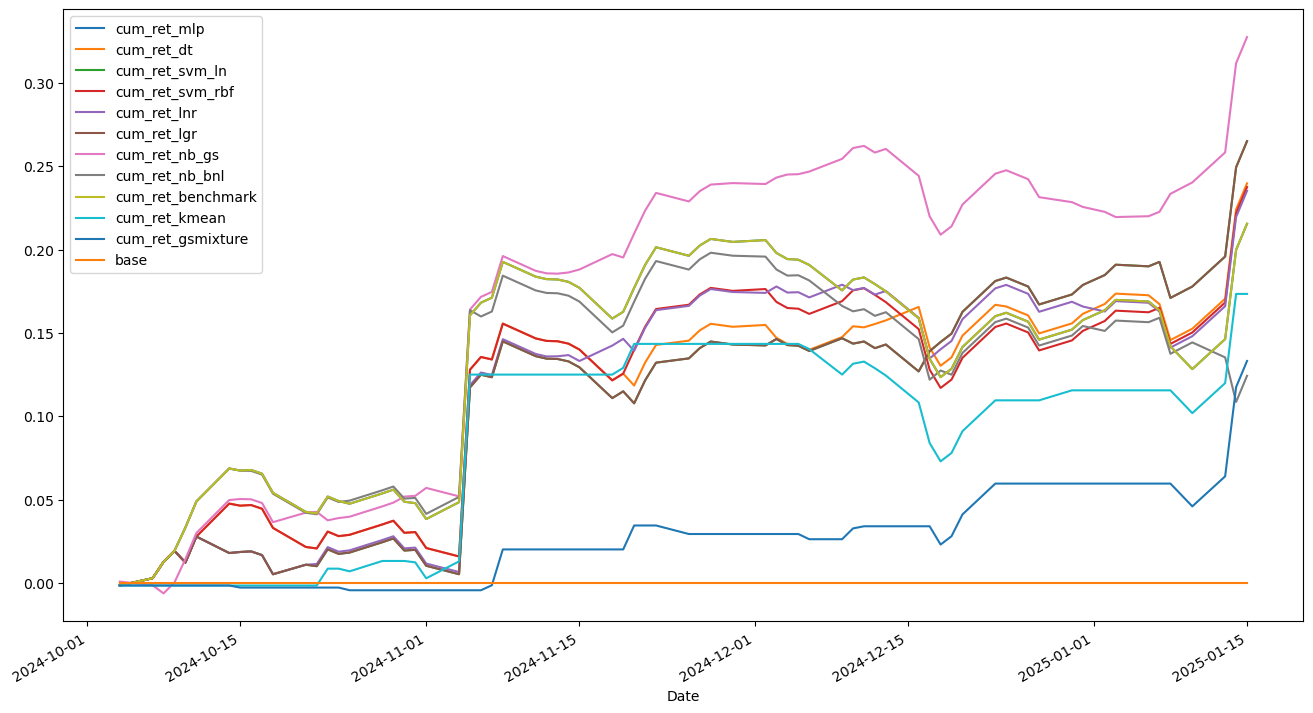

In [834]:
df_result['base'] = np.zeros((len(df_result), 1))
df_result.plot(figsize=(16,9))